# Example 1

This example reproduces a part of Figure 3 from Genkin et. al. 2024. We will load PMd recordings from the example neuron, optimize the model on this data, select the model and plot the results. 
Step 1: Check PSTHs. Load the data and plot PSTH aligned to stimulus onset and sorted by chosen side and stimulus difficulty.

data contains the following columns ['chosen_side', 'correct_response', 'stim_onset', 'RT', 'neuron_0', 'stim_difficulty']


Text(0, 0.5, 'PSTH, Hz')

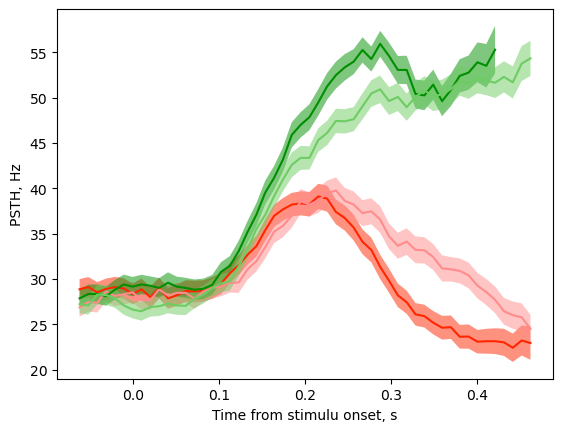

In [1]:
import os
import pickle
import zipfile
import pandas as pd
import numpy as np
import neuralflow
from neuralflow.utilities.psth import extract_psth
import matplotlib.pyplot as plt

# unzip the data
if 'single_neuron.pkl' not in os.listdir('data'):
    print('Exctracting zipped data')
    with zipfile.ZipFile('data/data_for_example.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

# read the data
with open('data/single_neuron.pkl', 'rb') as handle:
    data = pickle.load(handle)

print(f'data contains the following columns {list(data.columns)}')

# Extract the data for visualization
data_spiketimes, RTs = {}, {}
for chosen_side in ['Left', 'Right']:
    for stim_difficulty in ['easy', 'hard']:
        # Filter data for the current condition
        data_cur = data[(data.chosen_side == chosen_side) & (data.stim_difficulty == stim_difficulty)]
        
        # Align to stimulus onset
        data_cur = data_cur.assign(spikes = lambda x: x.neuron_0 - x.stim_onset, axis = 1)
        
        # For visualization, consider time window from stimulus_onset-0.1to RT 
        data_cur['spikes'] = data_cur.apply(lambda x: x.spikes[(x.spikes >= -0.1) & (x.spikes <= x.RT)], axis = 1)
        
        # Record reaction time and spikes
        RTs[f'{chosen_side}_{stim_difficulty}'] = data_cur['RT'].to_list()
        data_spiketimes[f'{chosen_side}_{stim_difficulty}'] = np.array([data_cur['spikes'].to_list(),], dtype = object)
        
# Plot PSTH
time_window = 0.075 # bin size
dt = 0.01 # bin step
tbegin=-0.1 # start time for PSTH
tend=0.500 # End time for PSTH

color_lines = {
    'Left_hard': '#FF8C8C', 'Left_easy':  [1.0, 0.15, 0.0],
    'Right_hard': [0.43, 0.80, 0.39], 'Right_easy': [0.0, 0.56, 0.0]
    }

for chosen_side in ['Left', 'Right']:
    for stim_difficulty in ['easy', 'hard']:
        tb, rates, rates_SEM = extract_psth(data_spiketimes[f'{chosen_side}_{stim_difficulty}'], RTs[f'{chosen_side}_{stim_difficulty}'], time_window, dt, tbegin, tend) 
        spikes = rates[0]
        time = tb[0][:spikes.size]
        err = rates_SEM[0]
        plt.plot(time,spikes,'-', color=color_lines[f'{chosen_side}_{stim_difficulty}'])
        plt.fill_between(time, spikes-err, spikes+err, color=color_lines[f'{chosen_side}_{stim_difficulty}'],alpha=0.5,
                        edgecolor = "none")
plt.xlabel('Time from stimulu onset, s')
plt.ylabel('PSTH, Hz')

Step 2: Extract the data, split into two datasamples, and convert it into ISI format which can be used for model optimization.

In [2]:
# In this work we analyze the data starting from 120 ms from stimulus onset. This accounts for the delay between stimulus onset
# and the emergence of decision-making dynamics in PMd
time_offset = 0.12
datasample1, datasample2 = {}, {}
for stim_difficulty in ['hard', 'easy']:
    for chosen_side in ['Left', 'Right']:
        # Filter data for the current condition
        data_cur = data[(data.chosen_side == chosen_side) & (data.stim_difficulty == stim_difficulty)].reset_index()
        
        # Align to stimulus onset and subtract time offset
        data_cur = data_cur.assign(spikes = lambda x: x.neuron_0 - x.stim_onset - time_offset, axis = 1)
        
        # For fitting, only consider spikes after stimulus onset and before reaction time
        data_cur['spikes'] = data_cur.apply(lambda x: x.spikes[(x.spikes >= 0) & (x.spikes <= x.RT - time_offset)], axis = 1)
        
        # time epoch
        data_cur['time_epoch'] = data_cur.RT.apply(lambda x: (0, x - time_offset))
        
        # Let's put even trials into datasample 1, and odd trials into datasample 2
        num_trials = data_cur.shape[0]
        shuffled_trial_numbers = np.random.permutation(range(num_trials))
        
        ind1 = np.arange(0, num_trials, 2)
        datasample1[f'{chosen_side}_{stim_difficulty}'] = neuralflow.SpikeData(
            data = np.array([data_cur.loc[ind1,'spikes'],], dtype = object), dformat = 'spiketimes', time_epoch = data_cur.loc[ind1, 'time_epoch'].to_list()
        )
        ind2 = np.arange(1, num_trials, 2)
        datasample2[f'{chosen_side}_{stim_difficulty}'] = neuralflow.SpikeData(
            data = np.array([data_cur.loc[ind2,'spikes'],], dtype = object), dformat = 'spiketimes', time_epoch = data_cur.loc[ind2, 'time_epoch'].to_list()
        )
        
        # Convert to ISI format
        datasample1[f'{chosen_side}_{stim_difficulty}'].change_format('ISIs')
        datasample2[f'{chosen_side}_{stim_difficulty}'].change_format('ISIs')



Step 3. Set up optimization parameters and run optimization

In [3]:
# The optimization was performed in a grid with Np = 8, Ne = 64. Here we set Ne to 16 to reduce fitting time
grid = neuralflow.GLLgrid(Np = 8, Ne = 16)

# Initial guess
init_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "cos_square", "params": {}},
    D = 1,
    fr_model = [{"model": "linear", "params": {"slope": 1, "bias": 100}}],
    params_size={'peq': 4, 'D': 1, 'fr': 1, 'p0': 1},
    grid = grid
)

optimizer = 'ADAM'

# In the paper we set max_epoch = 5000, mini_batch_number = 20, and did 30 line searches logarithmically scattered across 5000 epochs.
# Here we change these parameters to reduce optimization time
opt_params = {'max_epochs': 50, 'mini_batch_number': 20, 'params_to_opt': ['F', 'F0', 'D', 'Fr', 'C'], 'learning_rate': {'alpha': 0.05}}
ls_options = {'C_opt': {'epoch_schedule': [0,1,5,30], 'nSearchPerEpoch': 3, 'max_fun_eval': 2}, 'D_opt': {'epoch_schedule': [0,1,5,30], 'nSearchPerEpoch': 3, 'max_fun_eval': 25}}
boundary_mode = 'absorbing'

# Train on datasample 1
dataTR = [v for v in datasample1.values()]
optimization1 = neuralflow.optimization.Optimization(
                    dataTR,
                    init_model,
                    optimizer,
                    opt_params,
                    ls_options,
                    boundary_mode=boundary_mode
                )

# run optimization
print('Running optimization on datasample 1')
optimization1.run_optimization()

# Train on datasample 2
dataTR = [v for v in datasample2.values()]
optimization2 = neuralflow.optimization.Optimization(
                    dataTR,
                    init_model,
                    optimizer,
                    opt_params,
                    ls_options,
                    boundary_mode=boundary_mode
                )

# run optimization
print('Running optimization on datasample 1')
optimization2.run_optimization()

Running optimization on datasample 1


100%|██████████| 50/50 [06:47<00:00,  8.14s/it]


Running optimization on datasample 1


100%|██████████| 50/50 [05:52<00:00,  7.04s/it]


Step 4. Perform feature complexity analysis. Note that since here we only do 50 epochs, it is likely that we will not reach JS threshold yet, so the result will be underfitted. To get an optimal result, increase the number of epochs to ~300.
Also note that here we run the optimizaiton with decreased spatial resolution, with less line searches and so on. Therefore, the FC threshold might be crossed is a different point compared to the paper.

In [6]:
from neuralflow.feature_complexity.fc_base import FC_tools

JS_thres = 0.0015
FC_stride = 5
smoothing_kernel = 10

fc = FC_tools(non_equilibrium=True, model=init_model, boundary_mode=boundary_mode, terminal_time=1)
FCs1, min_inds_1, FCs2, min_inds_2, JS, FC_opt_ind = (
    fc.FeatureConsistencyAnalysis(optimization1.results, optimization2.results, JS_thres, FC_stride, smoothing_kernel)
    )

invert = fc.NeedToReflect(optimization1.results, optimization2.results)

Text(0, 0.5, 'Firing rate $f(x)$, Hz')

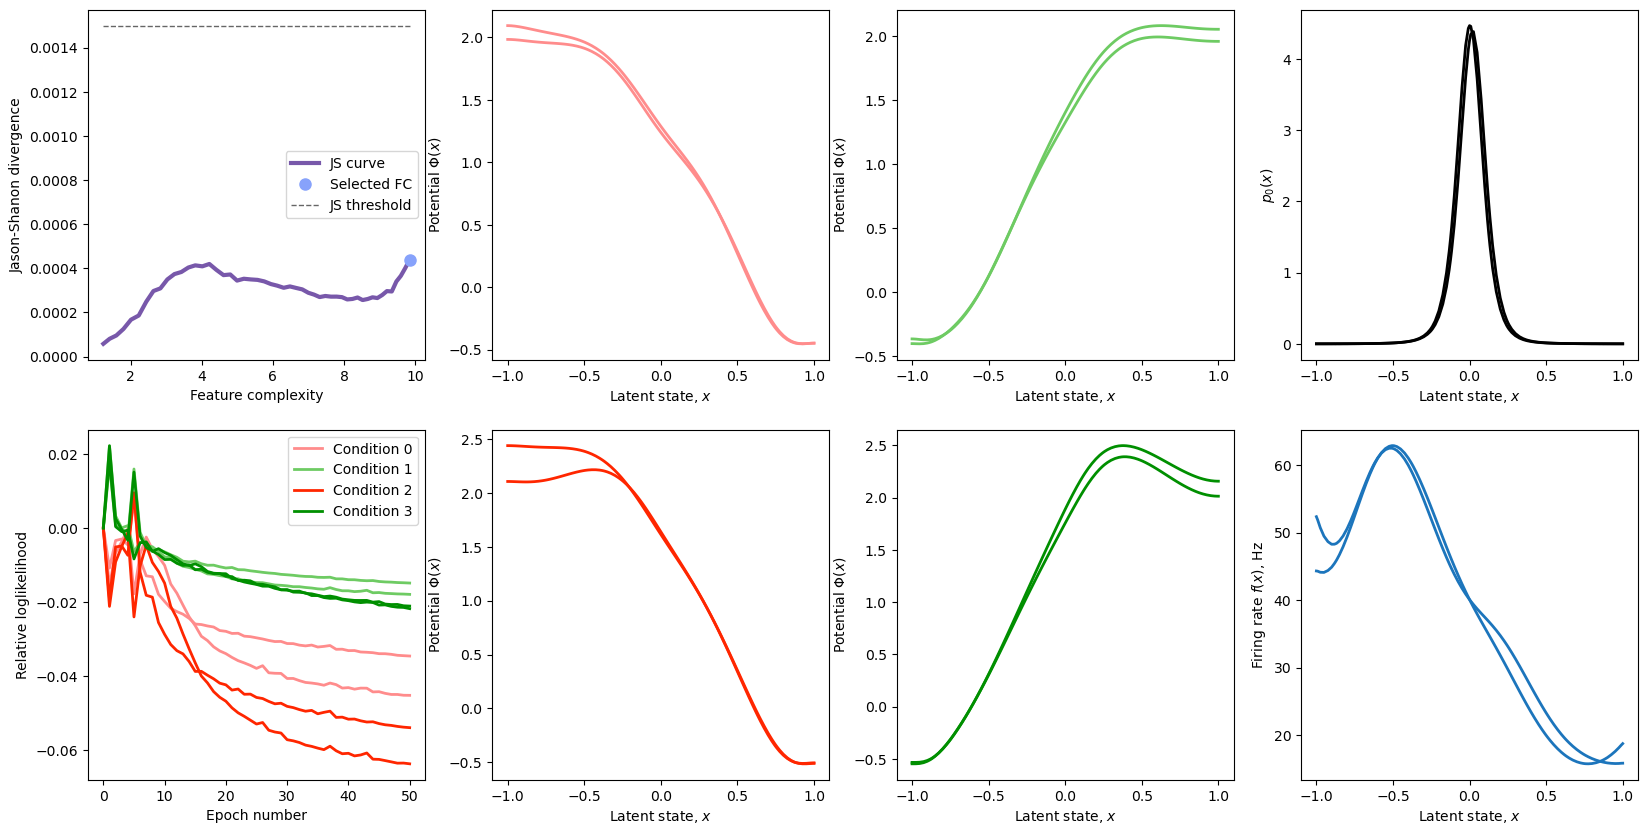

In [7]:
import matplotlib.gridspec as gridspec
  
color_lines = ['#FF8C8C', [0.431, 0.796, 0.388], [1, 0.149, 0], [0, 0.561, 0]]

fig = plt.figure(figsize = (20, 10))
gs = gridspec.GridSpec(2,4)

# Plot JS diveregence vs. FC
ax = plt.subplot(gs[0, 0])
ax.plot(FCs1, JS, linewidth = 3, color = [120/255, 88/255, 170/255], label = 'JS curve')
ax.plot(FCs1[FC_opt_ind], JS[FC_opt_ind], '.', markersize=16, color = '#87A2FB', label = 'Selected FC')
ax.plot(FCs1, JS_thres*np.ones_like(FCs1), '--', linewidth = 1, color = [0.4]*3, label = 'JS threshold')
plt.legend()
plt.xlabel('Feature complexity')
plt.ylabel('Jason-Shanon divergence')

# Plot negative relative scaled to start at 0)
# Note that for various reasons logliks may not monotinically decrease for the first few iteration.
ax = plt.subplot(gs[1, 0])
for cond in range(4):
    ll1 = optimization1.results['logliks'][cond]
    ll10 = ll1[0]
    ll1 = (ll1 - ll10) / np.abs(ll10)
    ll2 = optimization2.results['logliks'][cond]
    ll20 = ll2[0]
    ll2 = (ll2 - ll20) / np.abs(ll20)
    iter_nums = np.array(range(ll1.size)).astype('float64')
    ax.plot(iter_nums, ll1, color = color_lines[cond], linewidth = 2, label=f'Condition {cond}')
    ax.plot(iter_nums, ll2,color = color_lines[cond], linewidth = 2)
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Relative loglikelihood')
    
    

opt_ind_1 = min_inds_1[FC_opt_ind]
opt_ind_2 = min_inds_2[FC_opt_ind]
for cond in range(4):
    ax = plt.subplot(gs[cond//2, cond%2+1])
    # Note that original potential needs to be scaled back by D because we use non-conventional form of Langevin and Fokker-Planck equation.
    Phi1 = -np.log(optimization1.results['peq'][opt_ind_1][cond])*optimization1.results['D'][opt_ind_1][0]
    Phi2 = -np.log(optimization2.results['peq'][opt_ind_2][cond])*optimization2.results['D'][opt_ind_2][0]
    plt.plot(init_model.grid.x_d, Phi1, linewidth = 2, color = color_lines[cond])
    plt.plot(init_model.grid.x_d, Phi2[::-1 if invert else 1], linewidth = 2, color = color_lines[cond])
    plt.xlabel('Latent state, $x$')
    plt.ylabel('Potential $\Phi(x)$')
    
ax = plt.subplot(gs[0,3])
plt.plot(init_model.grid.x_d, optimization1.results['p0'][opt_ind_1][0], linewidth = 2, color = 'black')
plt.plot(init_model.grid.x_d, optimization2.results['p0'][opt_ind_2][0][::-1 if invert else 1], linewidth = 2, color = 'black')
plt.ylabel('$p_0(x)$')
plt.xlabel('Latent state, $x$')


fr_color = [28/255, 117/255, 188/255]
ax = plt.subplot(gs[1,3])
fr1 = optimization1.results['fr'][opt_ind_1][0,...,0]
fr2 = optimization2.results['fr'][opt_ind_2][0,...,0]
plt.plot(init_model.grid.x_d, fr1, linewidth = 2, color = fr_color)
plt.plot(init_model.grid.x_d, fr2[::-1 if invert else 1], linewidth = 2, color = fr_color)
plt.xlabel('Latent state, $x$')
plt.ylabel('Firing rate $f(x)$, Hz')